# Color Palette Clustering Evaluation
This notebook explores different methods for clustering colors in images to reconstruct original palettes from compressed/downscaled images.

In [1]:
%matplotlib ipympl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
from sklearn.cluster import KMeans, MeanShift, AgglomerativeClustering, estimate_bandwidth
from sklearn.metrics import silhouette_score
from skimage.color import rgb2lab, lab2rgb

In [2]:
# Load and preprocess image
def load_image_for_clustering(image_path):
    """
    Load an image and prepare it for color clustering
    Returns both RGB and flattened pixel arrays
    """
    # Load image using PIL
    img = Image.open(image_path)
    
    # Convert to RGB if needed
    if img.mode != 'RGB':
        img = img.convert('RGB')
    
    # Convert to numpy array
    img_array = np.array(img)
    
    # Flatten to get pixel colors as (N, 3) array
    pixels = img_array.reshape(-1, 3)
    
    return img_array, pixels

# Load the mario image
image_path = 'mario.png'
img_rgb, pixels = load_image_for_clustering(image_path)

print(f"Image shape: {img_rgb.shape}")
print(f"Number of pixels: {len(pixels)}")
print(f"Color value range: {pixels.min()} to {pixels.max()}")
print(f"Unique colors in image: {len(np.unique(pixels.view(np.dtype((np.void, pixels.dtype.itemsize*pixels.shape[1])))))}")

Image shape: (587, 640, 3)
Number of pixels: 375680
Color value range: 0 to 255
Unique colors in image: 54687


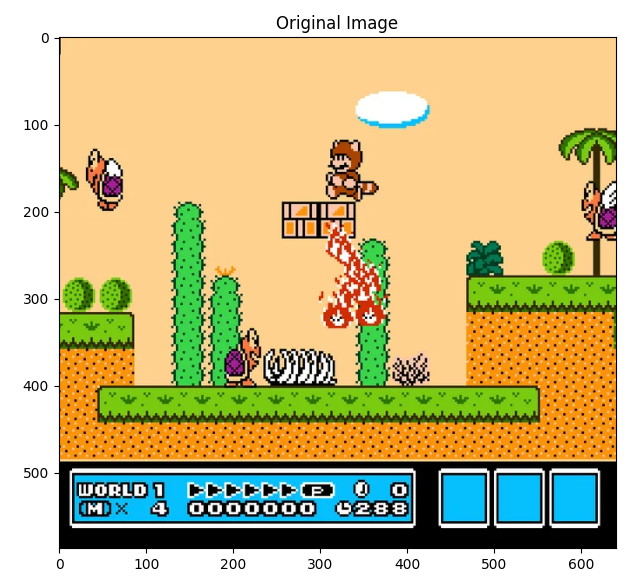

In [3]:
# Display original image at 1:1 pixel scale
def display_image_matplotlib(image_array, title="Image", figsize=None):
    """
    Display RGB image using matplotlib at 1:1 pixel scale
    """
    img_height, img_width = image_array.shape[:2]
    
    # Calculate figure size to maintain 1:1 pixel ratio
    if figsize is None:
        dpi = 100  # Standard DPI
        figsize = (img_width / dpi, img_height / dpi)
        # Limit maximum size for display
        max_size = 8
        if max(figsize) > max_size:
            scale = max_size / max(figsize)
            figsize = (figsize[0] * scale, figsize[1] * scale)
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(image_array, aspect='equal')
    ax.set_title(title)
    
    plt.tight_layout()
    return fig, ax

# Display original image
fig_original, ax_original = display_image_matplotlib(img_rgb, "Original Image")
plt.show()

In [4]:
# K-means clustering implementation
def kmeans_palette_clustering(pixels, n_colors=16):
    """
    Apply K-means clustering to extract color palette
    Returns cluster centers (palette) and labels for each pixel
    """
    # Apply K-means clustering
    kmeans = KMeans(n_clusters=n_colors, n_init=10)
    labels = kmeans.fit_predict(pixels)
    
    # Get cluster centers as the palette
    palette = kmeans.cluster_centers_.astype(np.uint8)
    
    inertia = kmeans.inertia_
    
    return palette, labels, {'inertia': inertia, 'kmeans_obj': kmeans}

In [5]:
# Reconstruct image using palette
def reconstruct_image_from_palette(original_shape, palette, labels):
    """
    Reconstruct image by mapping each pixel to its nearest palette color
    """
    # Map each pixel to its cluster center color
    reconstructed_pixels = palette[labels]
    
    # Reshape back to original image dimensions
    reconstructed_image = reconstructed_pixels.reshape(original_shape)
    
    return reconstructed_image

In [6]:
# Create color palette swatches visualization
def create_palette_swatches_matplotlib(palette, title="Color Palette", figsize=(8, 2)):
    """
    Create a visualization of color palette as swatches using matplotlib
    """
    n_colors = len(palette)
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Calculate grid dimensions
    cols = min(8, n_colors)  # Max 8 columns
    rows = (n_colors + cols - 1) // cols  # Ceiling division
    
    # Create color swatches
    for i, color in enumerate(palette):
        row = i // cols
        col = i % cols
        
        # Convert RGB to [0,1] range for matplotlib
        color_normalized = color / 255.0
        
        # Create rectangle patch
        rect = patches.Rectangle(
            (col, rows - row - 1), 1, 1,
            facecolor=color_normalized,
            edgecolor='black',
            linewidth=0.5
        )
        ax.add_patch(rect)
        
        # Add color index text
        ax.text(col + 0.5, rows - row - 0.5, str(i), 
               ha='center', va='center', fontsize=8, weight='bold',
               color='white' if np.mean(color_normalized) < 0.5 else 'black')
    
    # Set axis properties
    ax.set_xlim(0, cols)
    ax.set_ylim(0, rows)
    ax.set_aspect('equal')
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    
    plt.tight_layout()
    return fig, ax

In [7]:
# Create comprehensive comparison visualization using existing palette function
def create_clustering_comparison_matplotlib(original_img, reconstructed_img, palette, method_name, metrics):
    """
    Create a comprehensive comparison using matplotlib with subplots
    Uses the same logic as create_palette_swatches_matplotlib function
    """
    # Create figure with custom layout
    fig = plt.figure(figsize=(18, 6))
    gs = GridSpec(1, 3, figure=fig, height_ratios=[2], width_ratios=[1, 1, 1])
    
    # Original image
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.imshow(original_img)
    ax1.set_title('Original Image')
    ax1.set_xlabel('X (pixels)')
    ax1.set_ylabel('Y (pixels)')
    ax1.set_aspect('equal')
    
    # Reconstructed image
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.imshow(reconstructed_img)
    ax2.set_title(f'{method_name} Reconstructed')
    ax2.set_xlabel('X (pixels)')
    ax2.set_ylabel('Y (pixels)')
    ax2.set_aspect('equal')
    
    # Difference image
    ax3 = fig.add_subplot(gs[0, 2])
    diff_img = np.abs(original_img.astype(float) - reconstructed_img.astype(float)) / 255.0
    im3 = ax3.imshow(diff_img, cmap='hot')
    ax3.set_title('Absolute Difference')
    ax3.set_xlabel('X (pixels)')
    ax3.set_ylabel('Y (pixels)')
    ax3.set_aspect('equal')
    plt.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    
    return fig

# Create 3D scatter plot of pixels in color space
def create_3d_color_scatter(pixels, labels, palette, method_name, sample_size=10000):
    """
    Create a 3D scatter plot of pixels in RGB color space, colored by cluster labels
    """
    # Sample pixels for visualization to avoid overcrowding
    if len(pixels) > sample_size:
        sample_idx = np.random.choice(len(pixels), sample_size, replace=False)
        sample_pixels = pixels[sample_idx]
        sample_labels = labels[sample_idx]
    else:
        sample_pixels = pixels
        sample_labels = labels
    
    # Create figure
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Generate colors for each cluster using the palette
    n_clusters = len(palette)
    
    # Plot each cluster with its palette color
    for i in range(n_clusters):
        cluster_mask = sample_labels == i
        if np.any(cluster_mask):
            cluster_pixels = sample_pixels[cluster_mask]
            cluster_color = palette[i] / 255.0  # Normalize to [0,1] for matplotlib
            
            ax.scatter(
                cluster_pixels[:, 0],  # R
                cluster_pixels[:, 1],  # G
                cluster_pixels[:, 2],  # B
                c=[cluster_color],
                alpha=0.6,
                s=1,
                label=f'Cluster {i}'
            )
    
    # Plot cluster centers as larger points
    for i, center in enumerate(palette):
        ax.scatter(
            center[0], center[1], center[2],
            c=[center / 255.0],
            s=100,
            marker='x',
            edgecolors='black',
            linewidth=2
        )
    
    # Set labels and title
    ax.set_xlabel('Red')
    ax.set_ylabel('Green')
    ax.set_zlabel('Blue')
    ax.set_title(f'{method_name} - Color Space Clustering\n({len(sample_pixels)} sampled pixels)')
    
    # Set axis limits
    ax.set_xlim(0, 255)
    ax.set_ylim(0, 255)
    ax.set_zlim(0, 255)
    
    plt.tight_layout()
    return fig

In [8]:
# Complete evaluation pipeline for any clustering method
def evaluate_clustering_method(original_img, pixels, palette, labels, method_name):
    """
    Complete evaluation pipeline for any clustering method
    Takes palette and labels, reconstructs image, calculates metrics, and shows comparison
    """
    # Reconstruct image from palette and labels
    reconstructed_img = reconstruct_image_from_palette(original_img.shape, palette, labels)
    
    # Calculate standard metrics
    mse = np.mean((original_img.astype(float) - reconstructed_img.astype(float))**2)
    psnr = 20 * np.log10(255.0 / np.sqrt(mse)) if mse > 0 else float('inf')
    
    # Calculate silhouette score (with sampling for large datasets)
    if len(pixels) > 10000:
        sample_size = min(5000, len(pixels))
        sample_idx = np.random.choice(len(pixels), sample_size, replace=False)
        sample_pixels = pixels[sample_idx]
        sample_labels = labels[sample_idx]
        silhouette = silhouette_score(sample_pixels, sample_labels)
        print(f"Silhouette score calculated on {sample_size} sampled pixels")
    else:
        silhouette = silhouette_score(pixels, labels)
    
    # Prepare metrics dictionary
    metrics = {
        'silhouette_score': silhouette,
        'mse': mse,
        'psnr': psnr,
        'n_colors': len(palette)
    }
    
    # Print summary metrics
    print(f"\\n=== {method_name} Results ===")
    print(f"Colors: {len(palette)}")
    print(f"Silhouette Score: {silhouette:.4f}")
    print(f"MSE: {mse:.2f}")
    print(f"PSNR: {psnr:.2f} dB")
    
    # Create and show comparison visualization
    fig = create_clustering_comparison_matplotlib(
        original_img, reconstructed_img, palette, method_name, metrics
    )
    plt.tight_layout()
    plt.show()
    
    # Create and show 3D color space scatter plot
    fig_3d = create_3d_color_scatter(pixels, labels, palette, method_name)
    plt.show()
    
    return reconstructed_img, metrics

Silhouette score calculated on 5000 sampled pixels
\n=== K-means RGB (16 colors) Results ===
Colors: 16
Silhouette Score: 0.8028
MSE: 98.07
PSNR: 28.22 dB


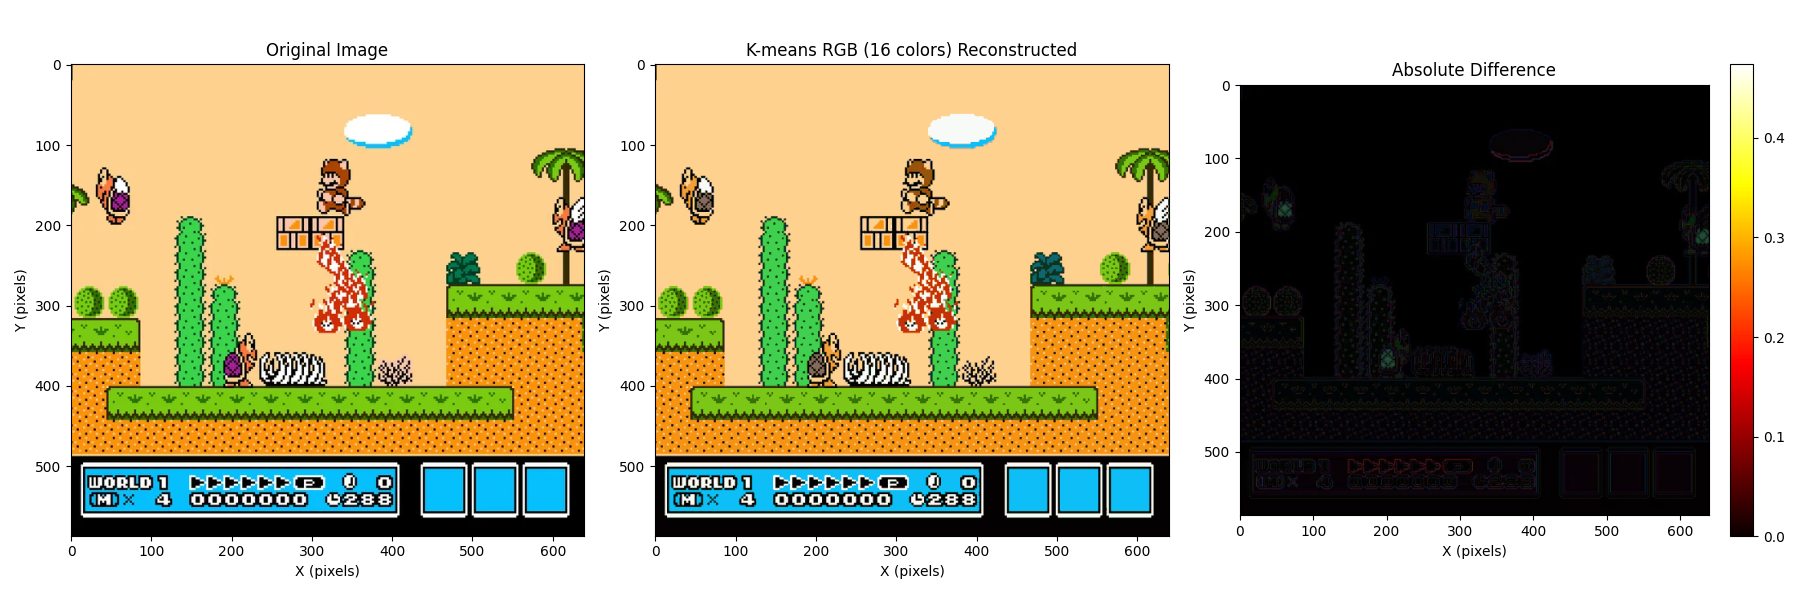

/tmp/ipykernel_6640/622445828.py:81: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


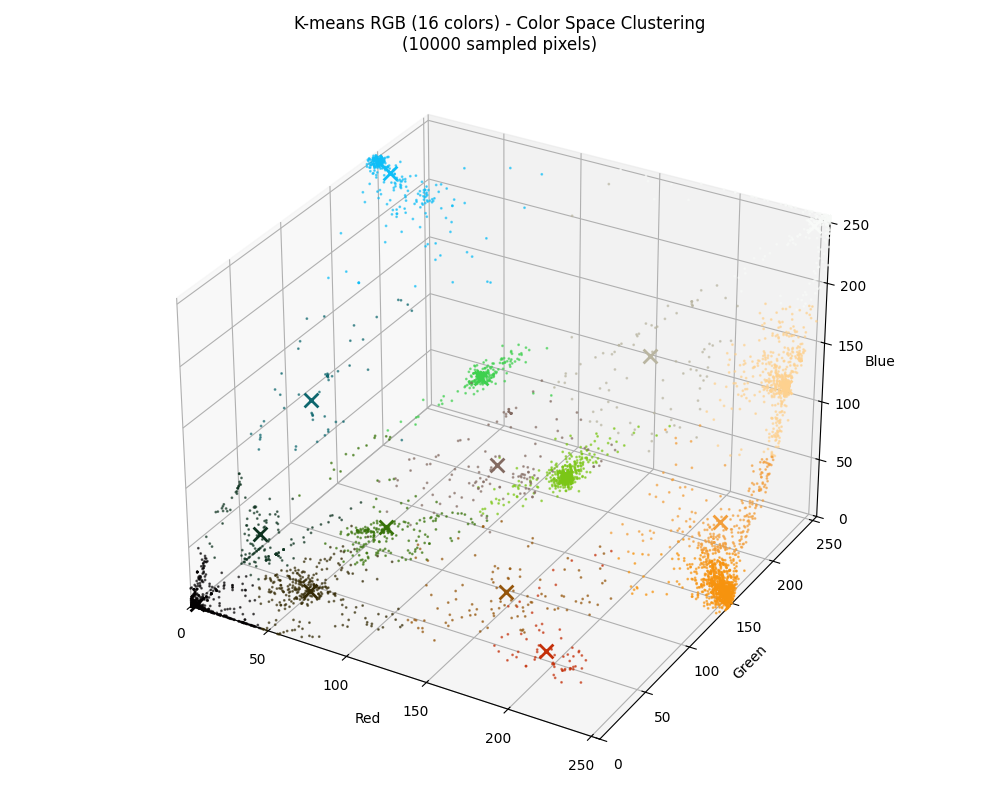

In [9]:
# RGB K-means clustering
for n_colors in [16]:
    palette_kmeans, labels_kmeans, _ = kmeans_palette_clustering(pixels, n_colors=n_colors)
    reconstructed_img, metrics = evaluate_clustering_method(img_rgb, pixels, palette_kmeans, labels_kmeans, f"K-means RGB ({n_colors} colors)")

Silhouette score calculated on 5000 sampled pixels
\n=== Agglomerative Clustering (18 colors) Results ===
Colors: 18
Silhouette Score: 0.7738
MSE: 92.92
PSNR: 28.45 dB


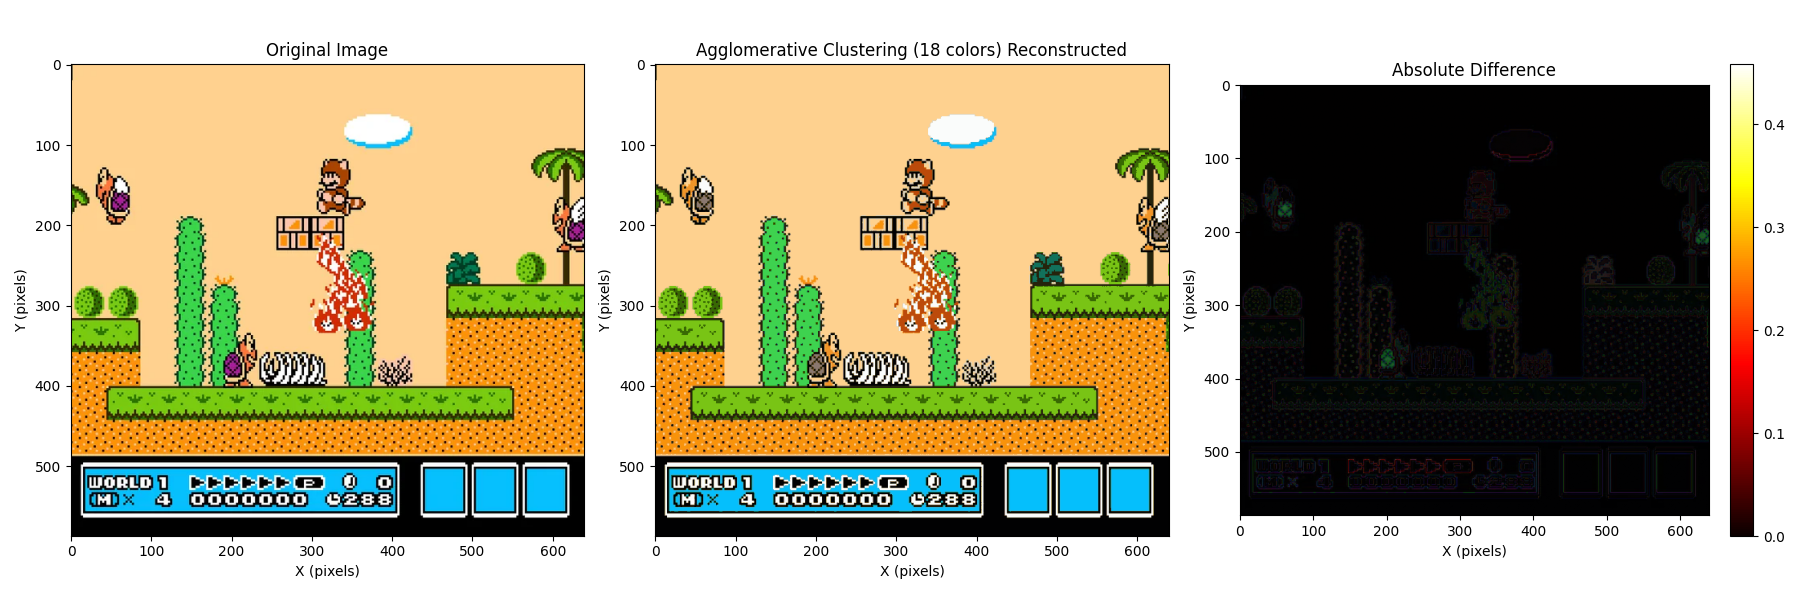

/tmp/ipykernel_6640/622445828.py:81: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


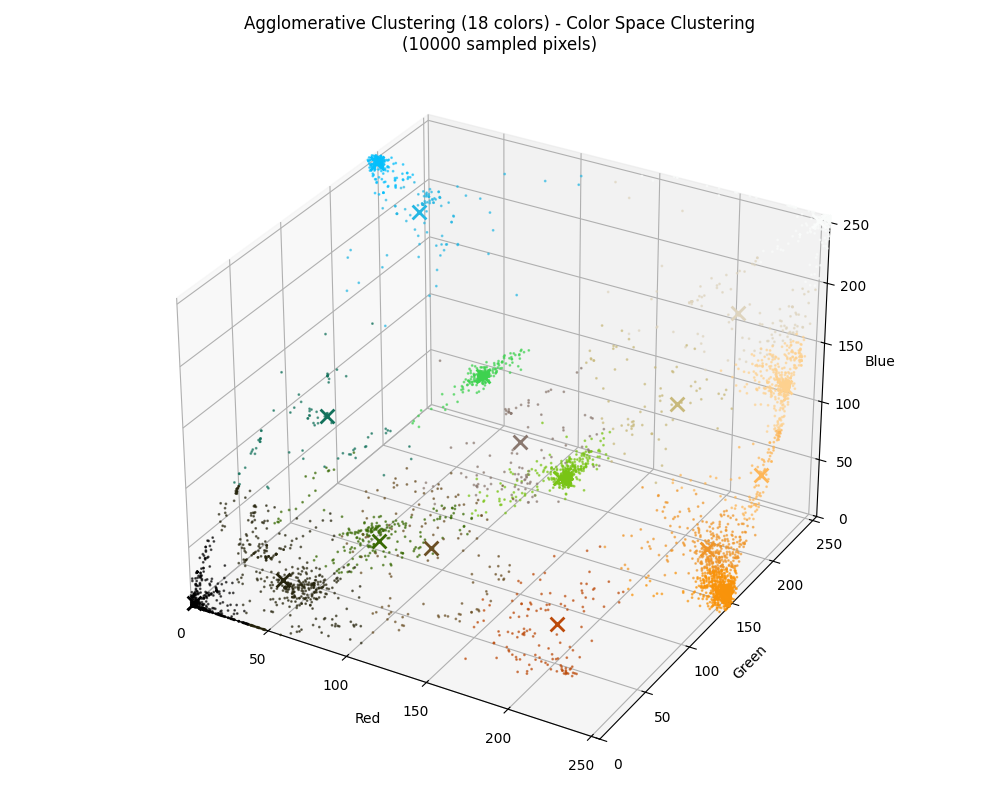

In [10]:
def agglomerative_clustering(pixels, distance_threshold=0.1, max_samples=5000):
    # Sample pixels to avoid memory issues
    if len(pixels) > max_samples:
        sample_idx = np.random.choice(len(pixels), max_samples, replace=False)
        sample_pixels = pixels[sample_idx]
    else:
        sample_pixels = pixels
    
    agglomerative = AgglomerativeClustering(n_clusters=None, distance_threshold=distance_threshold)
    sample_labels = agglomerative.fit_predict(sample_pixels)
    
    # Calculate cluster centers manually (AgglomerativeClustering doesn't have cluster_centers_)
    unique_labels = np.unique(sample_labels)
    palette = []
    for label in unique_labels:
        cluster_pixels = sample_pixels[sample_labels == label]
        cluster_center = np.mean(cluster_pixels, axis=0)
        palette.append(cluster_center)
    palette = np.array(palette, dtype=np.uint8)
    
    # Assign all pixels to closest cluster centers
    from sklearn.metrics.pairwise import euclidean_distances
    distances = euclidean_distances(pixels, palette)
    labels = np.argmin(distances, axis=1)
    
    return palette, labels

palette, labels = agglomerative_clustering(pixels, distance_threshold=400)
reconstructed_img, metrics = evaluate_clustering_method(img_rgb, pixels, palette, labels, f"Agglomerative Clustering ({len(palette)} colors)")

Silhouette score calculated on 5000 sampled pixels in Lab space
Silhouette score calculated on 5000 sampled pixels
\n=== K-means Lab (17 colors) Results ===
Colors: 17
Silhouette Score: 0.7714
MSE: 135.17
PSNR: 26.82 dB


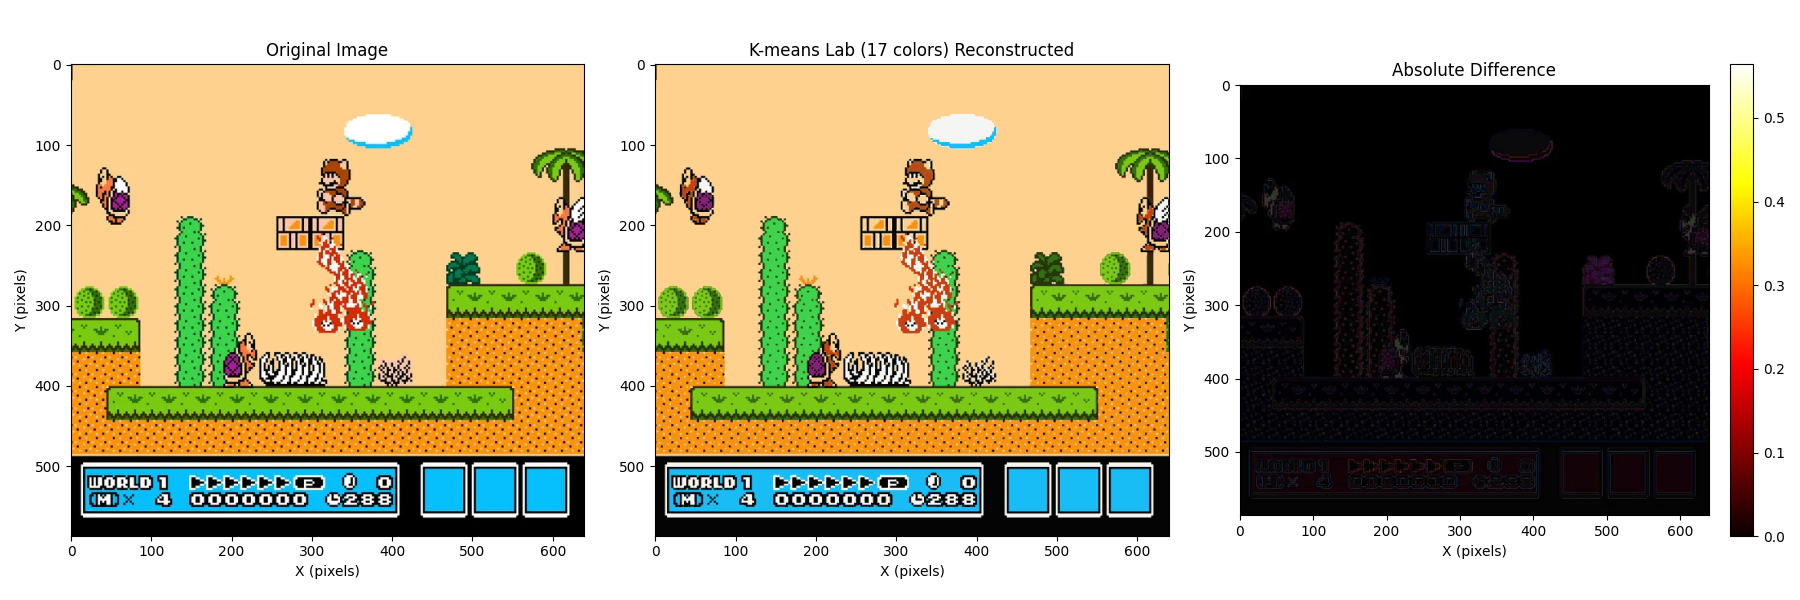

/tmp/ipykernel_6640/622445828.py:81: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


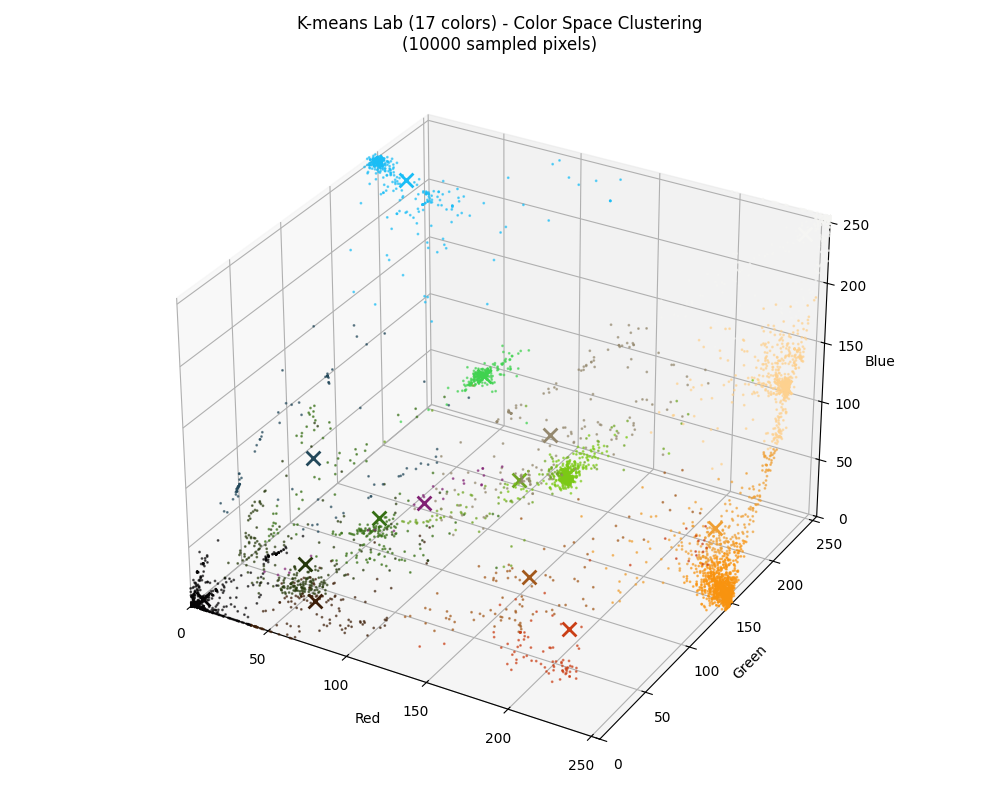

In [11]:
# K-means clustering in Lab colorspace
def kmeans_lab_clustering(pixels, n_colors=16):
    """
    Apply K-means clustering in Lab colorspace for perceptually uniform distances
    Returns cluster centers (palette) and labels for each pixel
    """
    # Convert RGB pixels to Lab colorspace
    # Reshape to image format for skimage conversion
    pixels_reshaped = pixels.reshape(1, -1, 3) / 255.0  # Normalize to [0,1]
    pixels_lab = rgb2lab(pixels_reshaped)
    pixels_lab_flat = pixels_lab.reshape(-1, 3)
    
    # Apply K-means clustering in Lab space
    kmeans = KMeans(n_clusters=n_colors, n_init=10)
    labels = kmeans.fit_predict(pixels_lab_flat)
    
    # Get cluster centers in Lab space
    palette_lab = kmeans.cluster_centers_
    
    # Convert palette back to RGB
    palette_lab_reshaped = palette_lab.reshape(1, -1, 3)
    palette_rgb = lab2rgb(palette_lab_reshaped)
    palette_rgb_flat = (palette_rgb.reshape(-1, 3) * 255).astype(np.uint8)
    
    # Calculate clustering quality metrics in Lab space
    if len(pixels_lab_flat) > 10000:
        sample_size = min(5000, len(pixels_lab_flat))
        sample_idx = np.random.choice(len(pixels_lab_flat), sample_size, replace=False)
        sample_pixels = pixels_lab_flat[sample_idx]
        sample_labels = labels[sample_idx]
        silhouette = silhouette_score(sample_pixels, sample_labels)
        print(f"Silhouette score calculated on {sample_size} sampled pixels in Lab space")
    else:
        silhouette = silhouette_score(pixels_lab_flat, labels)
    
    inertia = kmeans.inertia_
    
    return palette_rgb_flat, labels, {'silhouette_score': silhouette, 'inertia': inertia, 'kmeans_obj': kmeans}

# Lab colorspace K-means clustering
for n_colors in [17]:
    palette_lab, labels_lab, _ = kmeans_lab_clustering(pixels, n_colors=n_colors)
    reconstructed_img, metrics = evaluate_clustering_method(img_rgb, pixels, palette_lab, labels_lab, f"K-means Lab ({n_colors} colors)")

In [ ]:
# DBSCAN clustering implementation
from sklearn.cluster import DBSCAN

def dbscan_lab_clustering(pixels, eps=10, min_samples=50, max_samples=10000):
    """
    Apply DBSCAN clustering in Lab colorspace for perceptually uniform distances
    eps: maximum distance between samples in same neighborhood
    min_samples: minimum samples in neighborhood to form core point
    """
    # Sample pixels to make DBSCAN more manageable
    if len(pixels) > max_samples:
        sample_idx = np.random.choice(len(pixels), max_samples, replace=False)
        sample_pixels = pixels[sample_idx]
    else:
        sample_pixels = pixels
    
    # Convert RGB pixels to Lab colorspace
    # Reshape to image format for skimage conversion
    sample_pixels_reshaped = sample_pixels.reshape(1, -1, 3) / 255.0  # Normalize to [0,1]
    sample_pixels_lab = rgb2lab(sample_pixels_reshaped)
    sample_pixels_lab_flat = sample_pixels_lab.reshape(-1, 3)
    
    # Apply DBSCAN clustering in Lab space
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    sample_labels = dbscan.fit_predict(sample_pixels_lab_flat)
    
    # Get unique labels (excluding noise points labeled as -1)
    unique_labels = np.unique(sample_labels)
    if -1 in unique_labels:
        print(f"DBSCAN found {np.sum(sample_labels == -1)} noise points out of {len(sample_pixels)} samples")
        unique_labels = unique_labels[unique_labels != -1]
    
    if len(unique_labels) == 0:
        print("DBSCAN found no clusters, try reducing eps or min_samples")
        return None, None
    
    # Calculate cluster centers manually in Lab space
    palette_lab = []
    for label in unique_labels:
        cluster_pixels = sample_pixels_lab_flat[sample_labels == label]
        cluster_center = np.mean(cluster_pixels, axis=0)
        palette_lab.append(cluster_center)
    palette_lab = np.array(palette_lab)
    
    # Convert palette back to RGB
    palette_lab_reshaped = palette_lab.reshape(1, -1, 3)
    palette_rgb = lab2rgb(palette_lab_reshaped)
    palette_rgb_flat = (palette_rgb.reshape(-1, 3) * 255).astype(np.uint8)
    
    # Convert all pixels to Lab space for assignment
    pixels_reshaped = pixels.reshape(1, -1, 3) / 255.0  # Normalize to [0,1]
    pixels_lab = rgb2lab(pixels_reshaped)
    pixels_lab_flat = pixels_lab.reshape(-1, 3)
    
    # Assign all pixels to closest cluster centers in Lab space
    from sklearn.metrics.pairwise import euclidean_distances
    distances = euclidean_distances(pixels_lab_flat, palette_lab)
    labels = np.argmin(distances, axis=1)
    
    print(f"DBSCAN found {len(palette_rgb_flat)} clusters")
    
    return palette_rgb_flat, labels

# Try DBSCAN with different parameters in Lab space
for eps in [10]:
    print(f"\n--- DBSCAN Lab with eps={eps} ---")
    result = dbscan_lab_clustering(pixels, eps=eps, min_samples=30)
    if result[0] is not None:
        palette, labels = result
        reconstructed_img, metrics = evaluate_clustering_method(
            img_rgb, pixels, palette, labels, 
            f"DBSCAN Lab (eps={eps}, {len(palette)} colors)"
        )